# Mood Prediction

## Data Preprocessing

In [413]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import data_preprocessing as dprep
import train_test as tt

DATA_PATH = 'data/dataset_mood_smartphone.csv'

Uncomment this cell to rerun data preprocessing, otherwise we load it in the next one.

In [2]:
# #################################### LOAD DATA #########################################
# data, ids, variables = dprep.load_data(DATA_PATH)

# ############################ GET STATISTICS AND CLEAN DATA ###############################
# data = dprep.remove_5(data, variables)
# table = dprep.stats(data, variables)
# table2 = dprep.stats(data, variables) 


# ########################## GROUP DATA BY patient, DAY, VARIABLE ###############################    
# data_call_sms = data.loc[~data['variable'].isin(['mood','activity','circumplex.arousal','circumplex.valence'])].groupby(['id','time','variable']).sum().reset_index()
# data_else = data.loc[data['variable'].isin(['mood','activity','circumplex.arousal','circumplex.valence'])].groupby(['id','time','variable']).mean().reset_index()
# data = pd.concat([data_call_sms,data_else]).sort_values(by = ['id','time','variable'])

# ################################ DEALING WITH MISSING DATA ################################### 
# data =  dprep.fill_missing_data(data, ids, variables)
# data.to_csv(path_or_buf = 'data/data.csv')


# ###################### REMOVE DAYS WITH NO RELEVANT DATA(SPARSE DATA) #########################
# data = pd.crosstab(index = [data['id'],data['time']], 
#                    columns = data['variable'], values = data['value'], 
#                    aggfunc = lambda x:x).reset_index()

# # Swap 3rd column with mood, so later mood is the first column
# columns_new = data.columns.values.copy() 
# columns_new[2], columns_new[18] = columns_new[18], columns_new[2]
# data = data[columns_new]

# data = dprep.remove_days(data,ids)
# data.to_csv(path_or_buf = 'data/data.csv')

In [417]:
data, ids, variables = dprep.load_data(DATA_PATH)
data = pd.read_csv('data/data.csv',index_col=0)

In [418]:
################################## CORRELATION MATRXIX ####################################
total_corr, patient_corr, patient_mood_corr = dprep.correlation(data,ids)

####################### INDIVIDUALIZE DATA AND REMOVE INDIVIDUAL NaN DIMS ######################
patients_original = dprep.individualize(data, ids, patient_mood_corr)

Minimal dataset made out of the variables with the highest correlation

In [451]:
patients_minimal = {}
for k,v in patients_original.items():
    patients_minimal[k] = patients_original[k][['mood', 'circumplex.valence', 'circumplex.arousal']]

Create several datasets and apply several transformations

In the end we initially get data (n_samples, time_seq, features) which we can use for the LSTM.

We either average over the timesteps or flatten them for the SVM/other algorithms

In [779]:
period=3

def get_data(minimal=False, apply_std=True, apply_pca=True):
    if minimal:
        patients_data = patients_minimal
    else:
        patients_data = patients_original
        
    X_train, _, X_test, _ = tt.train_test(patients_data, None, ids, ratio_train=0.8)
    X_train_orig = X_train.copy()
    X_test_orig = X_test.copy()
    
    if apply_std:
        X_train, X_test = dprep.standardization(X_train, X_test, ids)
    if apply_pca:
        X_train, X_test = dprep.pca(X_train, X_test, ids)
        
    X_train, Y_train, X_test, Y_test = tt.make_sequences(X_train, X_test, X_train_orig, X_test_orig, period=period)
    return X_train, Y_train, X_test, Y_test, X_train_orig, X_test_orig

Choose full or minimal dataset here!

In [804]:
dataset = 'full'
if dataset == 'full':
    X_train, Y_train, X_test, Y_test, X_train_orig, X_test_orig = get_data()
else:
    X_train, Y_train, X_test, Y_test, X_train_orig, X_test_orig = get_data(minimal=True, apply_pca=False, apply_std=False)

In [805]:
avg_X_train, avg_X_test = map(tt.average_timesteps, [X_train, X_test])
reshaped_X_train, reshaped_X_test = map(tt.flatten_timesteps, [X_train, X_test])

We also create merged datasets with data from all users. This only works if the feature dimension is the same for every user which is not always the case (we need PCA applied, or the minimal dataset)

In [806]:
X_train_all, Y_train_all, X_test_all, Y_test_all = tt.train_test_all(X_train, Y_train, X_test, Y_test, ids)
avg_X_train_all, _, avg_X_test_all, _ = tt.train_test_all(avg_X_train, Y_train, avg_X_test, Y_test, ids)
reshaped_X_train_all, _, reshaped_X_test_all, _ = tt.train_test_all(reshaped_X_train, Y_train, reshaped_X_test, Y_test, ids)

Take the mean of the training set as a baseline

In [807]:
# Mean mood on the training set
avg = np.concatenate([x[:,0] for x in X_train_orig.values()]).mean()
baseline_all = ((Y_test_all - avg.mean())**2).mean()
baseline = np.array([((Y_test[k] - avg)**2).mean() for k in Y_test.keys()])
baseline_avg = np.average(baseline, weights=weights)

In [808]:
bench_predictions = tt.benchmark(X_test_orig, ids, period=period)
bench, bench_all = tt.prediction_stats(bench_predictions, Y_test, Y_test_all, ids, per_patient_only=False)
bench_avg = np.average(bench, weights=weights)
results=f'''
Benchmark average: {bench_avg}
Benchmark all: {bench_all}
Baseline average: {baseline_avg}
Baseline all: {baseline_all}
T-Test average: {ttest_rel(baseline, bench)}
R^2 avg: {1-(bench_avg/baseline_avg)}
R^2 all: {1-(bench_all/baseline_all)}'''
print(results)
with open(f'results/benchmark-{dataset}-{period}', 'w') as f: f.write(results)


Benchmark average: 0.5075710503450583
Benchmark all: 0.5030628047278427
Baseline average: 0.573200928209318
Baseline all: 0.5621562120708178
T-Test average: Ttest_relResult(statistic=0.7572506463682244, pvalue=0.4557080785320645)
R^2 avg: 0.11449715908396674
R^2 all: 0.10511919298248507


We choose the algorithm to work with using crossvalidation on the merged data.
We need one of the appropriate datasets for this

In [809]:
cross_validate_algorithm=False
if cross_validate_algorithm:
    algorithm = tt.choose_algorithm(avg_X_train_all, Y_train_all)
    print(f"Best algorithm is {algorithm}")
else:
    from sklearn.svm import SVR
    algorithm = SVR(kernel='rbf', gamma = 'scale', C=1)

In [810]:
def run_algorithm(algorithm, X_train, Y_train, X_test, Y_test,
                  X_train_all, Y_train_all, X_test_all, Y_test_all,
                  ids, bench_predictions, per_patient_only=False):
    svr_predictions = tt.regression(algorithm,
                                    X_train, Y_train, X_test,
                                    X_train_all, Y_train_all, X_test_all, 
                                    ids,
                                    per_patient_only=per_patient_only)
    svr, svr_all = tt.prediction_stats(svr_predictions, Y_test,Y_test_all,ids, per_patient_only=per_patient_only)
#     weights=[x.shape[0] for x in X_test_orig.values()]
#     svr,_=lstm_predictions([svr_predictions['all'],0],Y_test)
    svr_avg = np.average(svr, weights=weights)
    results=f'''
    Benchmark average: {bench_avg}
    Benchmark all: {bench_all}
    Baseline average: {baseline_avg}
    Baseline all: {baseline_all}
    SVM average: {svr_avg}
    SVM all: {svr_all}
    T-Test average: {ttest_rel(bench, svr)}
    T-Test average: {ttest_rel(baseline, svr)}
    R^2 avg: {1-(svr_avg/baseline_avg)}
    R^2 all: {1-(svr_all/baseline_all)}'''
    print(results)
    with open(f'results/svr-{dataset}-{period}.txt', 'w') as f: f.write(results)
    return bench, svr
    
bench, svr = run_algorithm(algorithm, avg_X_train, Y_train, avg_X_test, Y_test,
              avg_X_train_all, Y_train_all, avg_X_test_all, Y_test_all,
              ids, bench_predictions, per_patient_only=False)


    Benchmark average: 0.5075710503450583
    Benchmark all: 0.5030628047278427
    Baseline average: 0.573200928209318
    Baseline all: 0.5621562120708178
    SVM average: 0.540468778425498
    SVM all: 0.5601894199134047
    T-Test average: Ttest_relResult(statistic=-0.6213577717437195, pvalue=0.5397743835384238)
    T-Test average: Ttest_relResult(statistic=0.3331002904706209, pvalue=0.7417297976263126)
    R^2 avg: 0.05710414650945417
    R^2 all: 0.003498657695461649


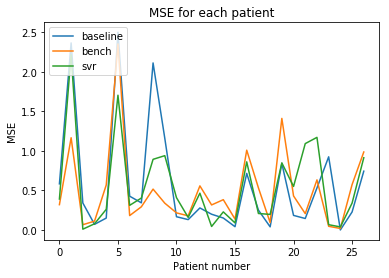

In [811]:
plt.figure()
plt.plot(baseline, label = 'baseline')
plt.plot(bench, label = 'bench')
plt.plot(svr, label = 'svr')
plt.title('MSE for each patient')
plt.xlabel("Patient number")
plt.ylabel("MSE")
plt.legend(loc='upper left')
plt.savefig(f'results/svr-{dataset}-{period}.png')
plt.show()

In [812]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from sklearn.metrics import mean_squared_error

def lstm(X_train_all, Y_train_all, X_test_all, Y_test_all, path='lstm_model.hdf5'):
    if os.path.exists(path):
        model = keras.models.load_model(path)
    else:
        val_percentage = 0.1
        X_train, X_val = X_train_all[int(len(X_train_all)*val_percentage):,:,:], X_train_all[:int(len(X_train_all)*val_percentage),:,:]
        Y_train, Y_val = Y_train_all[int(len(Y_train_all)*val_percentage):], Y_train_all[:int(len(Y_train_all)*val_percentage)]
        model = Sequential()
        model.add(LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
        # model.add(Dropout(rate=0.2))
        model.add(LSTM(10))
        # model.add(Dropout(rate=0.2))
        model.add(Dense(1))
        optimizer=keras.optimizers.SGD(lr=0.04, momentum=0.9, decay=1e-3, nesterov=True)
#         optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                      patience=5, min_lr=0.001)
    #     es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, 
    #                                        verbose=0, mode='min', baseline=None, 
    #                                        restore_best_weights=True)
        model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2,
                  validation_data=(X_test_all, Y_test_all),
                  callbacks=[reduce_lr])#,es])
        print(model.evaluate(X_test_all, Y_test_all))
        model.save(path)

    return model, (model.predict(X_test_all), model.evaluate(X_test_all, Y_test_all))
 

In [ ]:
model, preds = lstm(X_train_all, Y_train_all, X_test_all, Y_test_all, f'lstm_model_{dataset}_{period}.hdf5')

Train on 827 samples, validate on 184 samples
Epoch 1/100


In [ ]:
import itertools

def lstm_predictions(lstm_preds, Y_test):
    lens = [0]+list(itertools.accumulate(np.array([x.shape for x in Y_test.values()]).squeeze(),lambda x,y:x+y))
    mses = []
    for pid, (l1,l2) in zip(Y_test.keys(), zip(lens, lens[1:])):
        p = np.array(lstm_preds[0]).squeeze()
        pred = p[l1:l2]
        exp = Y_test[pid]
        mses.append(((pred-exp)**2).mean())
    return np.array(mses), lstm_preds[1]
lstm, lstm_all = lstm_predictions(preds, Y_test)

In [ ]:
bench_avg = np.average(bench, weights=weights)
lstm_avg = np.average(lstm, weights=weights)
results=f'''Benchmark average: {bench_avg}
Benchmark all: {bench_all}
LSTM average: {lstm_avg}
LSTM all: {lstm_all}
T-Test average benchmark: {ttest_rel(bench, lstm)}
T-Test average baseline: {ttest_rel(baseline, lstm)}
R^2 average: {1-(lstm_avg/baseline_avg)}
R^2 all: {1-(lstm_all/baseline_all)}'''
print(results)
with open(f'results/lstm-{dataset}-{period}.txt', 'w') as f: f.write(results)

In [ ]:
plt.figure()
plt.plot(baseline, label = 'baseline')
plt.plot(bench, label = 'bench')
plt.plot(lstm, label = 'lstm')
plt.title('MSE for each patient')
plt.xlabel("Patient number")
plt.ylabel("MSE")
plt.legend(loc='upper left')
plt.savefig(f'results/lstm-{dataset}-{period}.png')
plt.show()